'- In this notebook, we compute popular risk measures such as **Value at Risk (VaR)** and **Conditional VaR (CVaR)** using historical stock data, parametric fitting, and Monte Carlo simulations. We extract stock data using the `yfinance` package.
- For the first part, we ignore asset correlations and fit a univariate distribution to the aggregated portfolio returns. In the second part, we use multivariate distributions to account for correlations.
- **Goals:**
    - Fit historical data to normal and t-distributions, and compare their risk metric predictions.
    - Compare the effect of asset correlations by fitting the data to a multivariate distribution
    - Compare model and portfolio performance during **COVID-19** and **2008 Financial crisis**
        
        

In [104]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scipy.stats as stats

In [105]:
import pandas as pd
import yfinance as yf
import time

tickers = ['AAPL', 'MSFT', 'GOOG', 'NVDA', 'AMZN']
start_date = '2010-01-01'
end_date = '2019-12-01'

adj_close_data = {}

for ticker in tickers:
    print(f"Downloading {ticker}...")
    t = yf.Ticker(ticker)
    df = t.history(start=start_date, end=end_date)
    adj_close_data[ticker] = df['Close']  # or 'Adj Close' if available
    time.sleep(0.5)  # optional delay

# Combine into dataframe
data = pd.DataFrame(adj_close_data)
print(data.head())


                               AAPL       MSFT       GOOG      NVDA    AMZN
Date                                                                       
2010-01-04 00:00:00-05:00  6.431897  23.211449  15.517998  0.423854  6.6950
2010-01-05 00:00:00-05:00  6.443017  23.218941  15.449661  0.430044  6.7345
2010-01-06 00:00:00-05:00  6.340532  23.076445  15.060195  0.432794  6.6125
2010-01-07 00:00:00-05:00  6.328811  22.836464  14.709601  0.424313  6.5000
2010-01-08 00:00:00-05:00  6.370887  22.993944  14.905697  0.425230  6.6760


In [106]:
data.tail()

,AAPL,MSFT,GOOG,NVDA,AMZN
Date,,,,,
2019-11-22 00:00:00-05:00,63.295109,142.532684,64.384285,5.245522,87.286003
2019-11-25 00:00:00-05:00,64.404900,144.095306,64.948441,5.502213,88.692001
2019-11-26 00:00:00-05:00,63.901962,144.857559,65.289406,5.397497,89.847000
2019-11-27 00:00:00-05:00,64.760323,145.133896,65.261574,5.432345,90.925499
2019-11-29 00:00:00-05:00,64.617668,144.238220,64.862457,5.395007,90.040001


In [107]:
data.shape

(2495, 5)

C:\Users\manij\AppData\Local\Temp\ipykernel_39140\2207924783.py:2: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  returns = data.resample('M').last().pct_change().dropna()


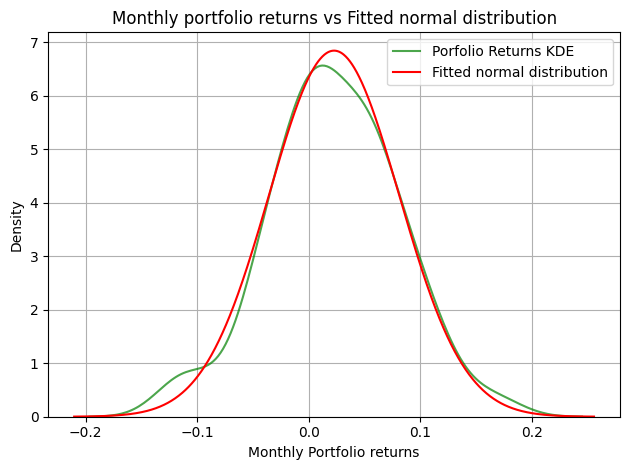

In [108]:
# returns = data.pct_change().dropna()
returns = data.resample('M').last().pct_change().dropna()

# Portfolio weights (equal weights as example)
weights = np.array([1/len(tickers)] * len(tickers))

# Portfolio daily returns -
portfolio_returns = returns.dot(weights)
mean = portfolio_returns.mean()
std_dev = portfolio_returns.std()
import seaborn as sns
sns.kdeplot(portfolio_returns, color='green', fill=False, alpha=0.7, label='Porfolio Returns KDE')
from scipy.stats import norm
x=np.linspace(mean-4*std_dev,mean+4*std_dev,1000)
plt.plot(x,norm.pdf(x, mean, std_dev),'r-', label='Fitted normal distribution')
plt.title('Monthly portfolio returns vs Fitted normal distribution')
plt.xlabel('Monthly Portfolio returns')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [109]:
from scipy.stats import shapiro
stat, p_value = shapiro(portfolio_returns)
print(f"Shapiro-Wilk p-value: {p_value:.4f}")


Shapiro-Wilk p-value: 0.7979


In [110]:
from scipy.stats import t, norm
# Fit both
df_t, loc_t, scale_t = t.fit(portfolio_returns)
loc_n, scale_n = norm.fit(portfolio_returns)

# Compute log-likelihoods
loglik_t = np.sum(t.logpdf(portfolio_returns, df_t, loc_t, scale_t))
loglik_n = np.sum(norm.logpdf(portfolio_returns, loc_n, scale_n))

# AIC = 2k - 2logL  (k = number of parameters)
AIC_t = 2*3 - 2*loglik_t  # t has 3 parameters
AIC_n = 2*2 - 2*loglik_n  # normal has 2 parameters

print(f"AIC (t): {AIC_t:.2f}")
print(f"AIC (normal): {AIC_n:.2f}")


AIC (t): -331.07
AIC (normal): -332.89


In [111]:
df_t, loc_t, scale_t

(np.float64(25.559695548857356),
 np.float64(0.022935969285651017),
 np.float64(0.05575959118725217))

In [112]:
from scipy.stats import kstest, t

# Perform K-S test for normal distribution
ks_stat_n, ks_p_n = kstest(portfolio_returns, 'norm', args=(mean, std_dev))
print(f"KS statistic (normal): {ks_stat_n:.4f}, p-value: {ks_p_n:.4f}")

# Perform K-S test
ks_stat, ks_p = kstest(portfolio_returns, 't', args=(df_t, loc_t, scale_t))
print(f"KS statistic: {ks_stat:.4f}, p-value: {ks_p:.4f}")


KS statistic (normal): 0.0406, p-value: 0.9856
KS statistic: 0.0428, p-value: 0.9756


## The normal is a better fit!

=== Portfolio Risk Metrics with Normal distribution (95% confidence) ===


Historical VaR: -0.0718
Parametric VaR: -0.0731
Monte Carlo VaR: -0.0731
Conditional VaR (CVaR): -0.1087


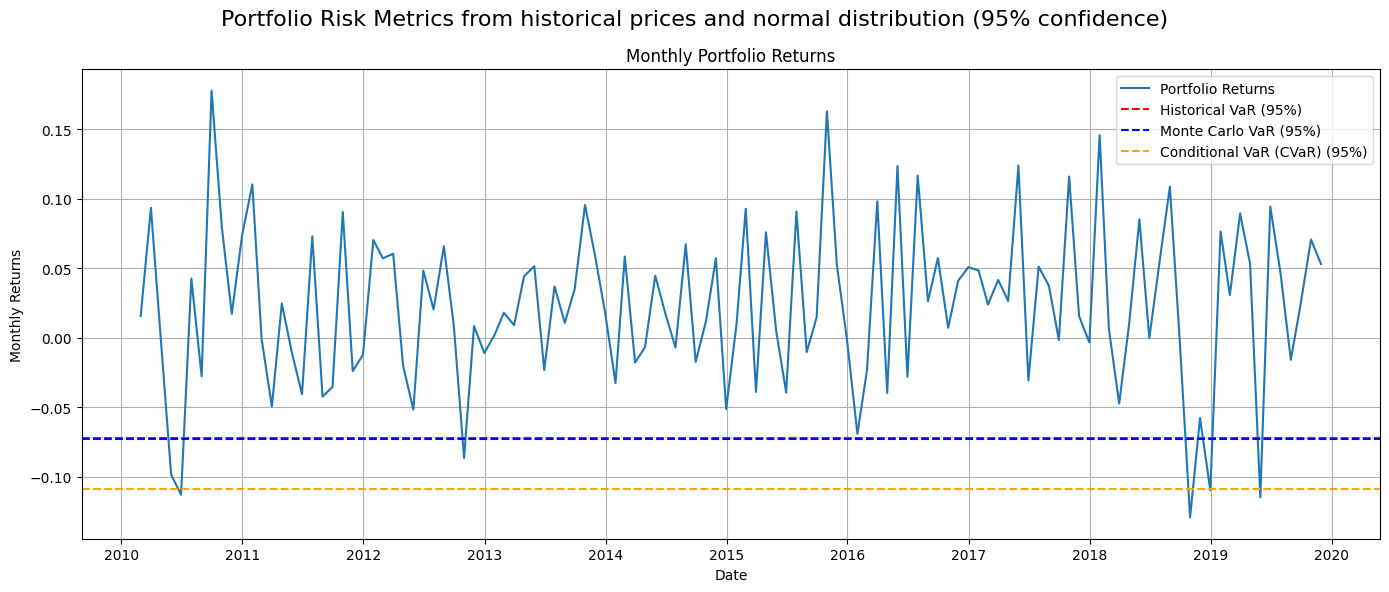

In [113]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats


confidence_level=0.95
#  Historical VaR 
hist_VaR = np.percentile(portfolio_returns, (1-confidence_level)*100) #Note: Historical VaR doesnt depend on the distribution

#  Parametric VaR (Variance-Covariance, assuming normality) 

param_VaR = stats.norm.ppf(1 - confidence_level, mean, std_dev)

#  Monte Carlo VaR (simulate 10,000 scenarios) 
n_simulations = 10000
simulated_returns = np.random.normal(mean, std_dev, n_simulations)
mc_VaR = np.percentile(simulated_returns, (1-confidence_level)*100)

#  Conditional VaR (CVaR) 
CVaR = portfolio_returns[portfolio_returns <= hist_VaR].mean()

# Print results
print(f"=== Portfolio Risk Metrics with Normal distribution ({confidence_level*100:.0f}% confidence) ===")
print(f"Historical VaR: {hist_VaR:.4f}")
print(f"Parametric VaR: {param_VaR:.4f}")
print(f"Monte Carlo VaR: {mc_VaR:.4f}")
print(f"Conditional VaR (CVaR): {CVaR:.4f}")

# Visualization: rolling historical VaR over time 
window = 10  # 10-month rolling window
rolling_VaR = portfolio_returns.rolling(window).apply(
    lambda x: np.percentile(x, (1-confidence_level)*100), raw=False
)
plt.figure(figsize=(14, 6))
plt.suptitle(f"Portfolio Risk Metrics from historical prices and normal distribution ({confidence_level*100:.0f}% confidence)", fontsize=16)
# plt.subplot(1,2,1)
plt.plot(portfolio_returns.index, portfolio_returns, label='Portfolio Returns')
plt.axhline(y=hist_VaR, color='red', linestyle='--', label=f'Historical VaR ({confidence_level*100:.0f}%)')
plt.axhline(y=mc_VaR, color='blue', linestyle='--', label=f'Monte Carlo VaR ({confidence_level*100:.0f}%)')
plt.axhline(y=CVaR, color='orange', linestyle='--', label=f'Conditional VaR (CVaR) ({confidence_level*100:.0f}%)')
plt.title('Monthly Portfolio Returns')  
plt.xlabel('Date')
plt.ylabel('Monthly Returns') 
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.subplot(1,2,2)
# plt.plot(portfolio_returns.index, (1 + portfolio_returns).cumprod() - 1
# , label='Cumulative Portfolio Return')
# plt.plot(rolling_VaR, label=f'Rolling {window}d Historical VaR ({confidence_level*100:.0f}%)', color='red')

# plt.title('Portfolio Risk Over Time')
# plt.xlabel('Date')
# plt.ylabel('Cumulative Return')
# plt.legend()
# plt.grid(True)
# plt.tight_layout()
# plt.show()

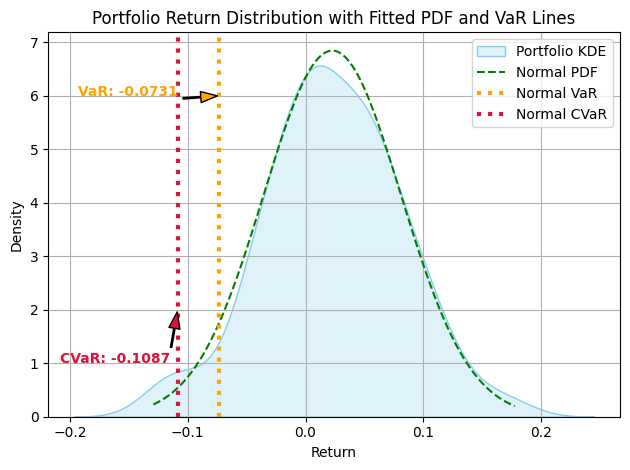

In [114]:
# Dashboard plot
x = np.linspace(portfolio_returns.min(), portfolio_returns.max(), 1000)
sns.kdeplot(portfolio_returns, fill=True, color='skyblue', label='Portfolio KDE')
plt.plot(x, norm.pdf(x, loc=mean, scale=std_dev), 'g--', label='Normal PDF')

# VaR lines
plt.axvline(param_VaR, color='orange', linestyle=':', linewidth = 3, label='Normal VaR')
plt.axvline(CVaR,color='crimson', linestyle=':', linewidth = 3, label = 'Normal CVaR')
plt.annotate(
    f'VaR: {param_VaR:.4f}',
    xy=(param_VaR, 6),
    xytext=(param_VaR-0.12, 6),
    arrowprops=dict(facecolor='orange', shrink=0.05, width=1, headwidth=8),
    color='orange',
    fontsize=10,
    fontweight='bold'
)
plt.annotate(
    f'CVaR: {CVaR:.4f}',
    xy=(CVaR, 2),
    xytext=(CVaR-0.1, 1),
    arrowprops=dict(facecolor='crimson', shrink=0.05, width=1, headwidth=8),
    color='crimson',
    fontsize=10,
    fontweight='bold'
)
plt.title('Portfolio Return Distribution with Fitted PDF and VaR Lines')
plt.xlabel('Return')
plt.ylabel('Density')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Now lets study the stock prices individually, and see if their correlations have an impact on the final predictions

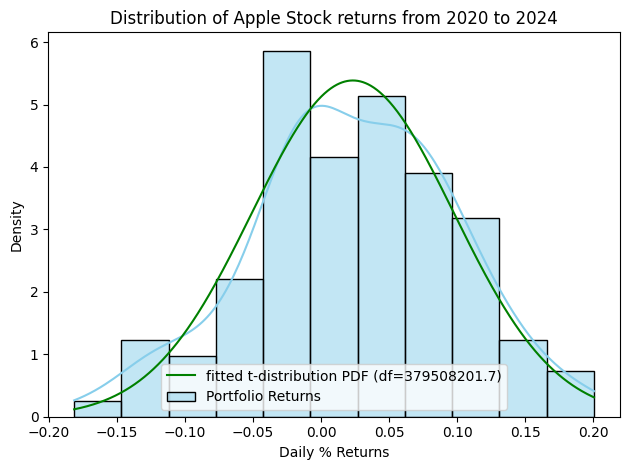

In [115]:
df,loc,scale = t.fit(returns['AAPL'])
fitted_norm=norm.fit(returns['AAPL'])
x= np.linspace(returns['AAPL'].min(), returns['AAPL'].max(), 1000)
sns.histplot(returns['AAPL'], kde=True, stat='density', color='skyblue', label='Portfolio Returns')
plt.plot(x, t.pdf(x, df, loc=loc, scale=scale), 'g-', label=f'fitted t-distribution PDF (df={df:.1f})')
#plt.plot(x, norm.pdf(x, loc=fitted_norm[0], scale=fitted_norm[1]), 'r-', label='Fitted Normal PDF')
plt.legend()
plt.title('Distribution of Apple Stock returns from 2020 to 2024')
plt.xlabel('Daily % Returns')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

In [116]:
returns_AAPL = returns['AAPL']
df_t, loc_t, scale_t = t.fit(returns_AAPL)
loc_n, scale_n = norm.fit(returns_AAPL)

# Compute log-likelihoods
loglik_t = np.sum(t.logpdf(returns_AAPL, df_t, loc_t, scale_t))
loglik_n = np.sum(norm.logpdf(returns_AAPL, loc_n, scale_n))

# AIC = 2k - 2logL  (k = number of parameters)
AIC_t = 2*3 - 2*loglik_t  # t has 3 parameters
AIC_n = 2*2 - 2*loglik_n  # normal has 2 parameters

print(f"AIC (t): {AIC_t:.2f}")
print(f"AIC (normal): {AIC_n:.2f}")

AIC (t): -273.33
AIC (normal): -275.33


In [117]:
ks_stat_n, ks_p_n = kstest(returns_AAPL, 'norm', args=(loc_n, scale_n))
print(f"KS statistic (normal): {ks_stat_n:.4f}, p-value: {ks_p_n:.4f}")

# Perform K-S test
ks_stat, ks_p = kstest(returns_AAPL, 't', args=(df_t, loc_t, scale_t))
print(f"KS statistic (t): {ks_stat:.4f}, p-value: {ks_p:.4f}")


KS statistic (normal): 0.0505, p-value: 0.9096
KS statistic (t): 0.0505, p-value: 0.9096


In [118]:
loc_n, scale_n, loc_t, scale_t, df_t

(np.float64(0.02340442057622227),
 np.float64(0.07408669972485547),
 np.float64(0.02340427121819051),
 np.float64(0.07408669370117175),
 np.float64(379508201.66698873))

## The data is highly normal

Text(0.5, 1.02, 'Pairplot of Stock Returns')

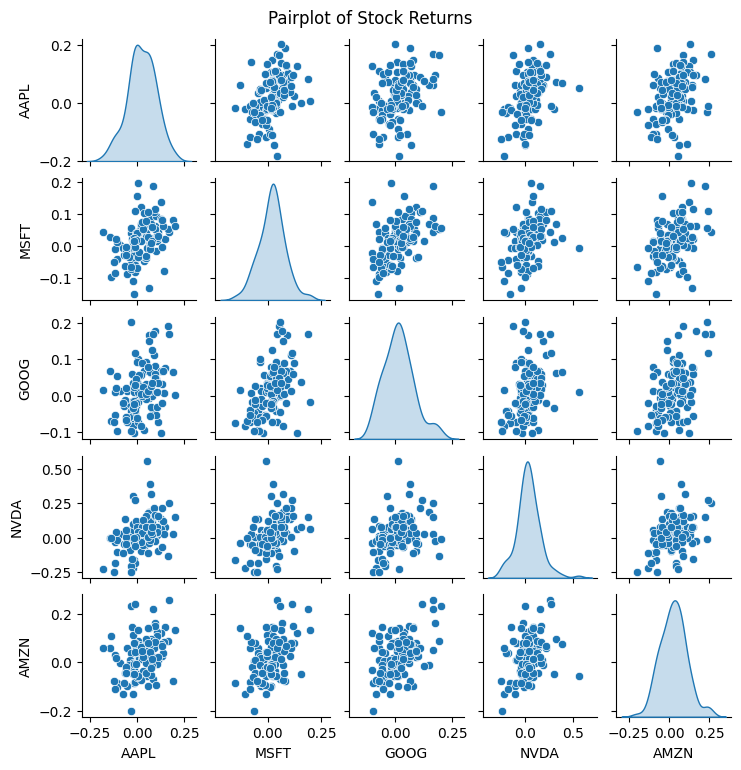

In [126]:
sns.pairplot(returns, diag_kind='kde', markers='o', height = 1.5)
plt.suptitle('Pairplot of Stock Returns', y=1.02)

## As we can see, all the stocks are strongly correlated with one another

Text(0.5, 1.0, 'Correlation Matrix of Stock Returns')

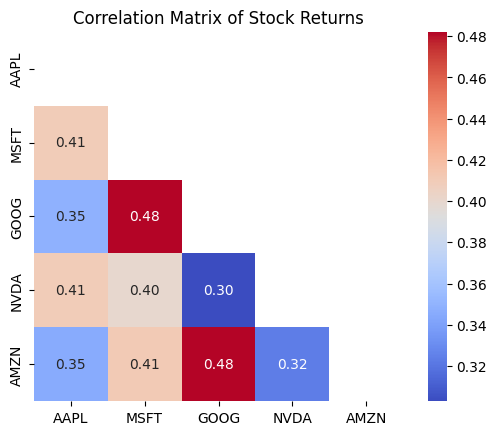

In [120]:

mask= np.triu(np.ones_like(returns.corr(), dtype=bool))
mask2 = returns.corr().abs() <= 1
sns.heatmap(returns.corr(), mask=mask & mask2,annot=True, cmap='coolwarm', fmt='.2f', square=True)
plt.title('Correlation Matrix of Stock Returns')

In [121]:
import numpy as np

n_samples = 10000
df = 3.7  # degrees of freedom (low df = fat tails)

# mean vector and covariance matrix from your return data
mean_vec = returns.mean().values           # shape: (n_assets,)
cov_matrix = returns.cov().values          # shape: (n_assets, n_assets)
n_assets = len(mean_vec)

# === Step 2: Simulate from multivariate normal ===
z = np.random.multivariate_normal(mean=mean_vec, cov=cov_matrix, size=n_samples)  # shape: (n_samples, n_assets)

#=== Step 3: Scale by sqrt of Gamma to get t-distribution ===
g = np.random.gamma(df / 2., 2. / df, size=n_samples)  # shape: (n_samples,)
scaling = np.sqrt(g)[:, None]  # reshape for broadcasting

# Simulate multivariate t
mvt_samples = mean_vec + (z - mean_vec) / scaling  # shape: (n_samples, n_assets)



=== Portfolio Risk Metrics with Multivariate t-distribution (95% confidence) ===
VaR_mvn: -0.0739
CVaR_mvn: -0.0990


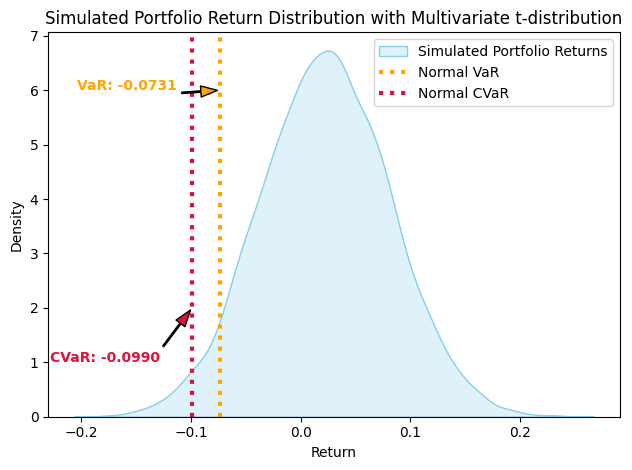

In [128]:
VaR_mvn = np.percentile(portfolio_returns_normal, (1-confidence_level)*100)
CVaR_mvn = portfolio_returns_normal[portfolio_returns_normal <= VaR_mvn].mean()
print(f"=== Portfolio Risk Metrics with Multivariate t-distribution ({confidence_level*100:.0f}% confidence) ===")
print(f"VaR_mvn: {VaR_mvn:.4f}")            
print(f"CVaR_mvn: {CVaR_mvn:.4f}")
# Dashboard plot        
x = np.linspace(portfolio_returns_normal.min(), portfolio_returns_normal.max(), 1000)
sns.kdeplot(portfolio_returns_normal, fill=True, color='skyblue', label='Simulated Portfolio Returns')
#plt.plot(x, no.pdf(x, df, loc=loc, scale=scale), 'g--', label=f't-distribution PDF (df={df:.1f})')
plt.axvline(VaR_mvn, color='orange', linestyle=':', linewidth = 3, label='Normal VaR')
plt.axvline(CVaR_mvn,color='crimson', linestyle=':', linewidth = 3, label = 'Normal CVaR')
plt.annotate(
    f'VaR: {param_VaR:.4f}',
    xy=(VaR_mvn, 6),
    xytext=(VaR_mvn-0.13, 6),
    arrowprops=dict(facecolor='orange', shrink=0.05, width=1, headwidth=8),
    color='orange',
    fontsize=10,
    fontweight='bold'
)
plt.annotate(
    f'CVaR: {CVaR_mvn:.4f}',
    xy=(CVaR_mvn, 2),
    xytext=(CVaR_mvn-0.13, 1),
    arrowprops=dict(facecolor='crimson', shrink=0.05, width=1, headwidth=8),
    color='crimson',
    fontsize=10,
    fontweight='bold'
)
plt.title('Simulated Portfolio Return Distribution with Multivariate t-distribution')
plt.legend()
plt.xlabel('Return')
plt.ylabel('Density')
plt.tight_layout()
plt.show()

In [124]:
covid_data = yf.download(tickers, start="2020-01-01", end="2020-12-01")['Close']
covid_returns = covid_data.resample('ME').last().pct_change().dropna().dot(weights)

covid_returns.values

[*********************100%***********************]  5 of 5 completed


array([-0.02916099, -0.04340728,  0.16584599,  0.0743736 ,  0.08947907,
        0.09725629,  0.15434917, -0.0692492 , -0.02075132,  0.07088104])

[*********************100%***********************]  5 of 5 completed


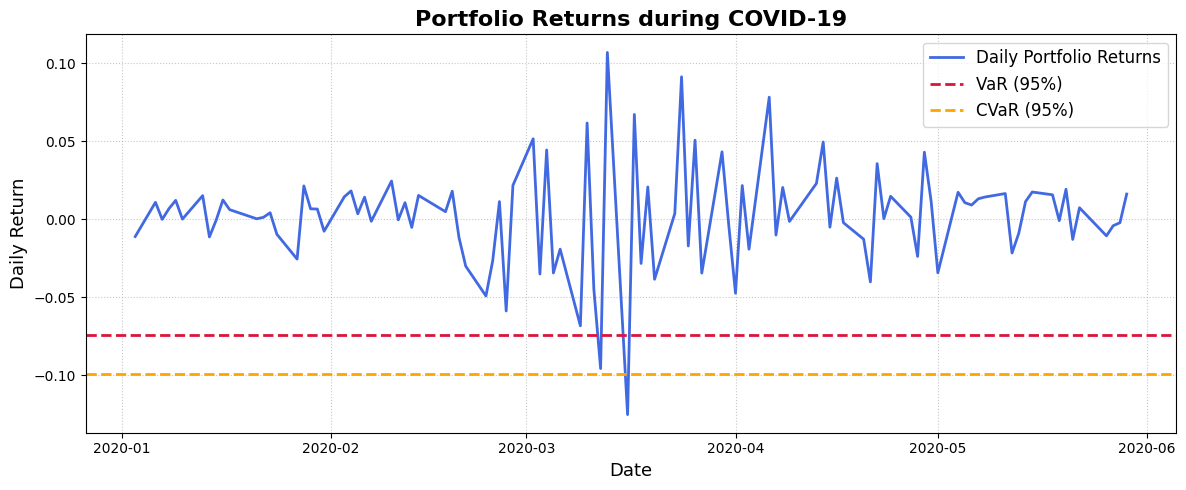

In [129]:
covid_data = yf.download(tickers, start="2020-01-01", end="2020-06-01")['Close']
covid_returns = covid_data.pct_change().dropna().dot(weights)

plt.figure(figsize=(12, 5))
plt.plot(covid_returns.index, covid_returns, label='Daily Portfolio Returns', color='royalblue', linewidth=2)
plt.axhline(y=VaR_mvn, color='crimson', linestyle='--', linewidth=2, label=f'VaR ({confidence_level*100:.0f}%)')
plt.axhline(y=CVaR_mvn, color='orange', linestyle='--', linewidth=2, label=f'CVaR ({confidence_level*100:.0f}%)')
plt.title('Portfolio Returns during COVID-19', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=13)
plt.ylabel('Daily Return', fontsize=13)
plt.legend(fontsize=12, frameon=True)
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

## With this model and portfolio, the CVaR and VaR would have been breached only once

[*********************100%***********************]  5 of 5 completed


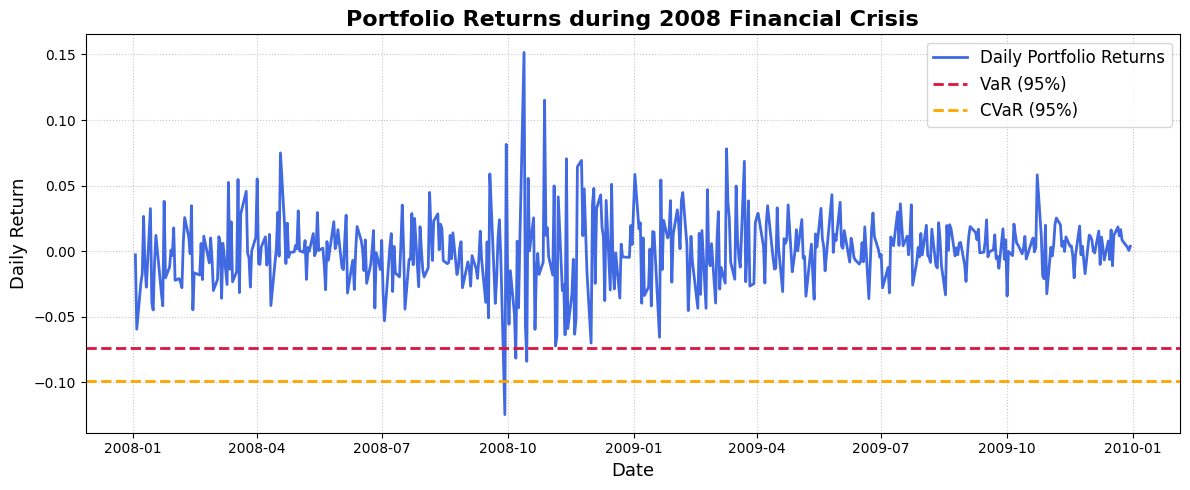

In [132]:
crisis_data = yf.download(tickers, start="2008-01-01", end="2009-12-31")['Close']
crisis_returns = crisis_data.pct_change().dropna().dot(weights)

plt.figure(figsize=(12, 5))
plt.plot(crisis_returns.index, crisis_returns, label='Daily Portfolio Returns', color='royalblue', linewidth=2)
plt.axhline(y=VaR_mvn, color='crimson', linestyle='--', linewidth=2, label=f'VaR ({confidence_level*100:.0f}%)')
plt.axhline(y=CVaR_mvn, color='orange', linestyle='--', linewidth=2, label=f'CVaR ({confidence_level*100:.0f}%)')
plt.title('Portfolio Returns during 2008 Financial Crisis', fontsize=16, fontweight='bold')
plt.xlabel('Date', fontsize=13)
plt.ylabel('Daily Return', fontsize=13)
plt.legend(fontsize=12, frameon=True)
plt.grid(True, linestyle=':', alpha=0.7)
plt.tight_layout()
plt.show()

## The CVaR would have been breached only one, the VaR thrice

In [134]:
# Final Data Report: VaR and CVaR Before and After Correlations

report = pd.DataFrame({
    'Method': [
        'Historical (No Correlation)',
        'Parametric Normal (No Correlation)',
        'Monte Carlo Normal (No Correlation)',
        'Multivariate t (With Correlation)'
    ],
    'VaR': [
        hist_VaR,
        param_VaR,
        mc_VaR,
        VaR_mvn
    ],
    'CVaR': [
        CVaR,
        CVaR,  # Parametric CVaR not separately calculated, using historical CVaR
        CVaR,  # Monte Carlo CVaR not separately calculated, using historical CVaR
        CVaR_mvn
    ]
})

print("=== Portfolio Risk Metrics: VaR and CVaR Before and After Correlations ===")
display(report.style.format({'VaR': '{:.4f}', 'CVaR': '{:.4f}'}))

=== Portfolio Risk Metrics: VaR and CVaR Before and After Correlations ===


,Method,VaR,CVaR
0,Historical (No Correlation),-0.0718,-0.1087
1,Parametric Normal (No Correlation),-0.0731,-0.1087
2,Monte Carlo Normal (No Correlation),-0.0731,-0.1087
3,Multivariate t (With Correlation),-0.0739,-0.0990


- **Downloaded historical price data** for a portfolio of large-cap tech stocks (**AAPL**, **MSFT**, **GOOG**, **NVDA**, **AMZN**) using `yfinance`.
- **Computed monthly returns** and constructed an **equally weighted portfolio**.
- **Visualized the empirical distribution** of portfolio returns and compared it to **fitted normal** and **Student's t-distributions**.
- **Calculated Value at Risk (VaR)** and **Conditional VaR (CVaR)** using:
    - Historical method
    - Parametric (normal and t)
    - Monte Carlo simulation
- **Found that the normal distribution provides a better fit** to the empirical return distribution, especially in the tails.
- **Analyzed individual stock return distributions** and visualized **pairwise correlations** using pairplots and heatmaps.
- **Simulated portfolio returns** using both **multivariate normal** and **multivariate t-distributions** to account for asset correlations.
- **Observed that incorporating asset correlations and fat tails** (via the multivariate normal) **doesn't affect risk metrics**, this can be attributed to the effect of monthly averaging
- **Applied the methodology to COVID-19 and 2008 financial crisis period data** to observe risk under extreme market conditions.